# Knight's tour #

A knight's tour is a sequence of moves of a knight on a chessboard such that the knight visits every square exactly once. If the knight ends on a square that is one knight's move from the beginning square (so that it could tour the board again immediately, following the same path), the tour is closed; otherwise, it is open. (source: [Wikipedia](https://en.wikipedia.org/wiki/Knight%27s_tour))

Below, the implementation of our recursive algorithm:

## Recursive Algorithm ##

In [1]:
import numpy as np
from math import floor
import sys

In [3]:
def SolveBoard(n,x,y,chess_board):
    # check if the initial points are correct
    if x<n and y<n:
        solution = RecursiveKnightTour(n, chess_board, x, y, count = 1)
        if solution == True:
            print("Solution found!")
            print(np.array(chess_board))
        else:
            print("No solution found.")
    else:
        print("insert correct initial points")

# n: number of rows/columns, x & y are the coordinates, count is the number of correct moves     
def RecursiveKnightTour(n, chess_board, x, y, count):
    ## basic step: the counter reached all the cells, we found a solution
    if count == (n * n)+1:
        return True
    # unavailable values for coordinate x,y
    if (x < 0) or (x >= n) or (y < 0) or (y >= n) or chess_board[x][y] != 0:
        return False
    ## Recursive step
    chess_board[x][y] = count
    for x_move, y_move in zip([2, 1, 2, 1, -2, -1, -2, -1], [1, 2, -1, -2, 1, 2, -1, -2]):
        # if this direction reached the solution, return True
        if RecursiveKnightTour(n, chess_board, x + x_move, y + y_move, count+1):
            return True
    # Dead point: reset current position and go back.
    # Also, if there are no back-steps, there are no solutions to the tour
    chess_board[x][y] = 0
    return False

In [4]:
# set the number of rows and columns (nxn) in the chessboard (max 7 to solve it in feasible time)
n=6
chess_board = [[0 for i in range(n)] for j in range(n)]

# initial position
x=0
y=0

SolveBoard(n, x, y, chess_board)

Solution found!
[[ 1 30 33 22 25 12]
 [34 21 26 13 32 23]
 [29  2 31 24 11 14]
 [20 35 18 27  8  5]
 [17 28  3  6 15 10]
 [36 19 16  9  4  7]]


## Warnsdorff's Algorithm ##

The Warnsdorff's Algorithm has a simple rule: _always move to an adjacent, unvisited square with minimal degree_. It means that we don't have to explore every available move like in the brute-force approach, but just moving into the cell with less possible moves from it (unvisited square with minimal degree).

Below, the implementation of our Warnsdorff's Algorithm:

In [5]:
def GetMoves(x,y,n):
    pos_x = (2, 1, 2, 1, -2, -1, -2, -1)
    pos_y = (1, 2, -1, -2, 1, 2, -1, -2)
    possible_moves = []
    # check if the move in a certain direction is legal
    for i in range(8):
        if x+pos_x[i] >= 0 and x+pos_x[i] < n and y+pos_y[i] >= 0 and y+pos_y[i] < n and chess_board[x+pos_x[i]][y+pos_y[i]] == 0:
            possible_moves.append([x+pos_x[i], y+pos_y[i]])

    return possible_moves


# n: number of rows/columns, x & y are the coordinates
def Solve(x,y,n,chess_board):
    # check if the initial points are correct
    if x<n and y<n:
        x = x
        y = y
        chess_board[x][y] = 1
        counter = 2
    
        for i in range((n*n)-1):
            possible_moves = GetMoves(x,y,n)
            
            if len(possible_moves)==0:
                print("No solution found from ",x,",",y)
                break
            
            minimum = possible_moves[0]
            # comparing the degree of every cell in the list of possible moves and getting the one with minimal degree
            for p in possible_moves:
                if len(GetMoves(p[0],p[1],n)) <= len(GetMoves(minimum[0],minimum[1],n)):
                    minimum = p
            x = minimum[0]
            y = minimum[1]
            #print(x,y)
            chess_board[x][y] = counter
            counter += 1
            
        if counter==n*n+1:
            print("Solution found!")
            
    else:
        print("insert correct initial points")
        
    print(np.array(chess_board))

In [7]:
# set the number of rows/columns (nxn) in the chess board
n=100

chess_board = [[0 for i in range(n)] for j in range(n)]

# initial position
x=0
y=0

Solve(x,y,n,chess_board)

# resetting the chessboard to recompile this cell
chess_board = [[0 for i in range(n)] for j in range(n)]

Solution found!
[[   1  200  209 ...  270  521  268]
 [ 208  205    2 ...  267   50  271]
 [ 199  210  207 ... 2768  269  520]
 ...
 [ 380 7421  378 ... 3977   98  101]
 [ 151  376 7423 ...  100 3979  324]
 [7422  379  150 ...  325  102   99]]


## Divide and Conquer ##

The following solution is inspired by Ian Parberry's paper: "[An efficient algorithm for the Knight's tour problem](https://www.mimuw.edu.pl/~rytter/TEACHING/ALCOMB/parberry_algoknight.pdf)"

We saw that the Warnsdorff’s algorithm is fast also for $m \geq 6$ (where $m$ is the number of rows/columns), but it has a problem: it does not always succeed. As explained better in the paper "[A SIMPLE ALGORITHM FOR KNIGHT’S TOURS](https://sites.science.oregonstate.edu/math_reu/proceedings/REU_Proceedings/Proceedings2004/2004Ganzfried.pdf)" by Sam Ganzfried:$\newline$
"[...]The algorithm produces a successful tour over 85% of the time on most boards with $m$ less than 50, and it succeeds over 50% of the time on most boards with m less than 100. However, for $m > 200$ the success rate is less than 5%, and for $m > 325$ there were no successes at all. These observations suggest that the success rate of Warnsdorff’s random algorithm rapidly goes to $0$ as $m$ increases." $\newline$ This can also be seen in the below graph:

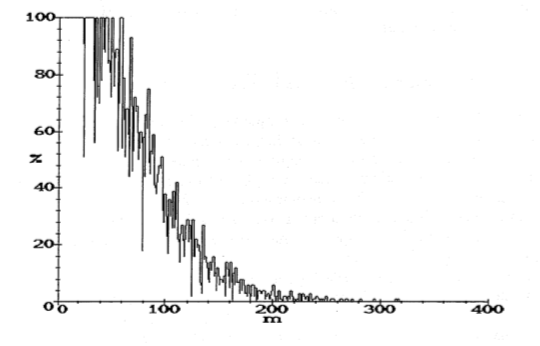
<center>Fig. 1</center>

We need an algorithm that is succesfull also with large $m$. Then, we introduce the Divide and Conquer approach thought by Ian Parberry. As he said in the Theorem 2.1 above, there exist a knight's tour for all $m > 6$. To construct such tours, we need to split large boards into smaller boards until we reach a _base case_: a board with a given closed solution (we will explain later why it need to be closed). We will take care only of large boards that are multiples of our base case (board $8\times 8$):

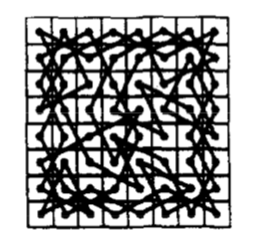
<center>Fig. 2</center>

Once we know the tour for our base case, we can solve boards with $m = k8$, where $k \in \mathbb{N}$. To do this, we need to explain how we manage the splitted boards. When $k\geq 2$, we split the board into $4$ boards. Intuitevely, if the new boards have $k\geq 2$ they are splitted recursively until we reach boards with $m=8$.

For convenience, to solve the tour we will always start it with the board in the bottom left corner. Once we reach the upper corner of this board, instead to make move $D$ (fig. 2(b)) and complete the tour in the bottom left board, we will make move E (fig. 2(c)) and we enter in the upper left board. Once we explore all the upper left board, instead of closing the tour with move $A$ we go to the upper right bo with move F. With the same reasoning we complete the upper right board and then the bottom right board. We then re-enter in the bottom left board and we complete the tour. 


The image below is a graphic representation of Ian Parberry's idea:

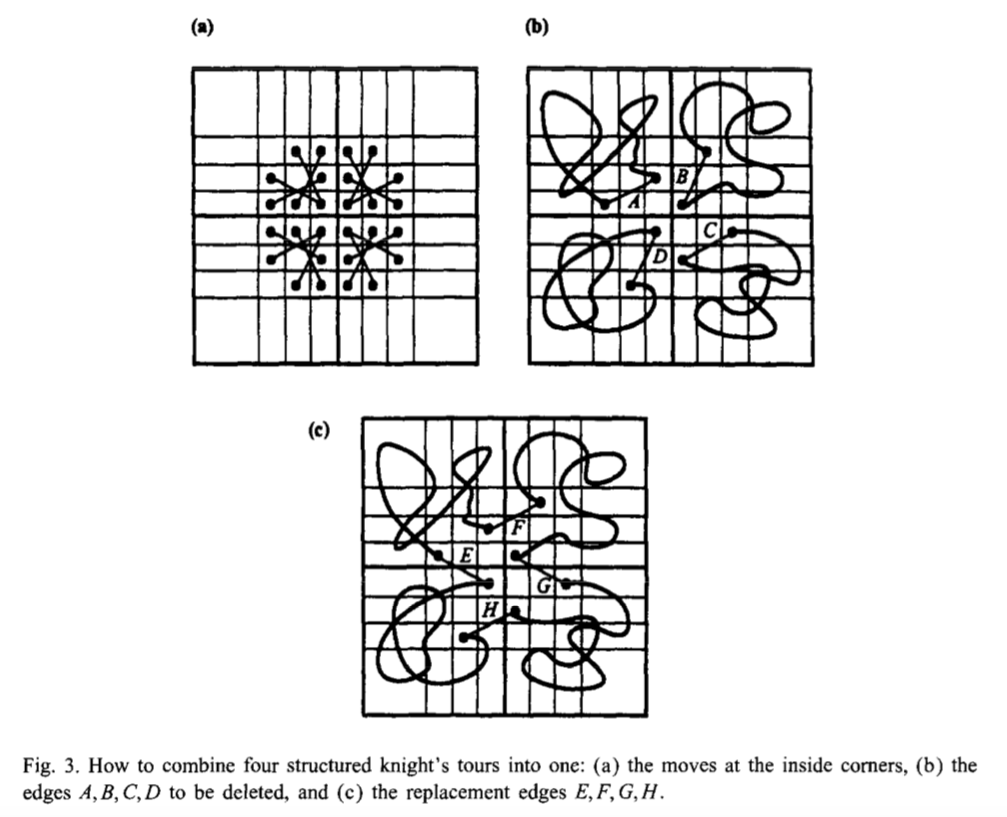

Notice that every time the tour is closed such as the base case. This _closeness_ allows us to broke the tour in the corners, having a one-step connection between the first and last visited cell in the sub-board.

Below, the implementation of our Parberry's Divide and Conquer approach:

In [11]:
### KNIGHT MOVES
KnightMoves = {(-2,-1),(-1,-2),(+1,-2),(+2,-1),(+2,+1),(+1,+2),(-1,+2),(-2,+1)}

######### 8x8 #########
##    # # # # # # # # 8
##    # # # # # # # # 7
##    # # # # # # # # 6
##    # # # # # # # # 5
##    # # # # # # # # 4
##    # # # # # # # # 3
##    # # # # # # # # 2
##    # # # # # # # # 1
##    1 2 3 4 5 6 7 8

### Already given closed knight's tour for 8x8 chess board (base case).
### As seen in fig. 2:
tour8x8 = {
    (1,1): [(2,3),(3,2)], (2,3): [(3,1),(1,1)],
    (3,1): [(1,2),(2,3)], (1,2): [(2,4),(3,1)],
    (2,4): [(1,6),(1,2)], (1,6): [(2,8),(2,4)],
    (2,8): [(3,6),(1,6)], (3,6): [(1,5),(2,8)],
    (1,5): [(2,7),(3,6)], (2,7): [(4,8),(1,5)],
    (4,8): [(6,7),(2,7)], (6,7): [(8,8),(4,8)],
    (8,8): [(7,6),(6,7)], (7,6): [(8,4),(8,8)],
    (8,4): [(6,5),(7,6)], (6,5): [(7,7),(8,4)],
    (7,7): [(8,5),(6,5)], (8,5): [(7,3),(7,7)],
    (7,3): [(8,1),(8,5)], (8,1): [(6,2),(7,3)],
    (6,2): [(4,1),(8,1)], (4,1): [(2,2),(6,2)],
    (2,2): [(1,4),(4,1)], (1,4): [(2,6),(2,2)],
    (2,6): [(1,8),(1,4)], (1,8): [(3,7),(2,6)],
    (3,7): [(5,8),(1,8)], (5,8): [(6,6),(3,7)],
    (6,6): [(8,7),(5,8)], (8,7): [(6,8),(6,6)],
    (6,8): [(4,7),(8,7)], (4,7): [(3,5),(6,8)],
    (3,5): [(4,3),(4,7)], (4,3): [(5,5),(3,5)],
    (5,5): [(3,4),(4,3)], (3,4): [(1,3),(5,5)],
    (1,3): [(2,1),(3,4)], (2,1): [(4,2),(1,3)],
    (4,2): [(5,4),(2,1)], (5,4): [(4,6),(4,2)],
    (4,6): [(3,8),(5,4)], (3,8): [(1,7),(4,6)],
    (1,7): [(2,5),(3,8)], (2,5): [(3,3),(1,7)],
    (3,3): [(5,2),(2,5)], (5,2): [(4,4),(3,3)],
    (4,4): [(6,3),(5,2)], (6,3): [(7,1),(4,4)],
    (7,1): [(8,3),(6,3)], (8,3): [(7,5),(7,1)],
    (7,5): [(5,6),(8,3)], (5,6): [(6,4),(7,5)],
    (6,4): [(4,5),(5,6)], (4,5): [(5,7),(6,4)],
    (5,7): [(7,8),(4,5)], (7,8): [(8,6),(5,7)],
    (8,6): [(7,4),(7,8)], (7,4): [(8,2),(8,6)],
    (8,2): [(6,1),(7,4)], (6,1): [(5,3),(8,2)],
    (5,3): [(7,2),(6,1)], (7,2): [(5,1),(5,3)],
    (5,1): [(3,2),(7,2)], (3,2): [(1,1),(5,1)]
}

In [12]:
### n is the number of rows/columns of the board.
### It split succesfully only if n is a multiple of 8.
def Split(n):
    if n/8 == floor(n/8):
        new_lenght = n/2
        return int(new_lenght)
    else:
        print("Failed to split", n, "in two parts")
        sys.exit('ERROR: Failed to split into 8x8 sub-boards')
    

In [19]:
class Chessboard:
    
    def __init__(self, rows, columns):
        self.rows = rows
        self.columns = columns
        self.KnightPathList = {}
        self.knightTour = {}
        
    def SetPathList(self, KnightPathList):
        self.KnightPathList = KnightPathList.copy()
    
    def GetPathList(self):
        return self.KnightPathList.copy()
    
    def SetTour(self, tour):
        self.knightTour = tour.copy()
    
    def GetTour(self):
        return self.knightTour.copy()
    
    def GetRows(self):
        return self.rows
    
    def GetColumns(self):
        return self.columns
    
    ## FindPathList allows us to create a new path list given the magnitude of the chessboard
    def FindPathList(self):
        nRows = self.GetRows()
        nColumns = self.GetColumns()        
        
        ## Base case: we set the tour for the above given chess boards
        if (nRows == 8) and (nColumns == 8):
            self.SetPathList(tour8x8)
            return
            
        ## Recursive case: we split the boards (into 4 equal subBoards) until we find a base case
        newRows = Split(nRows)
        newColumns = Split(nColumns)
        
        
        topLeftBoard = Chessboard(newRows, newColumns)
        topRightBoard = Chessboard(newRows, newColumns)
        bottomLeftBoard = Chessboard(newRows, newColumns)
        bottomRightBoard = Chessboard(newRows, newColumns)
        
        topLeftBoard.FindPathList()
        topRightBoard.FindPathList()
        bottomLeftBoard.FindPathList()
        bottomRightBoard.FindPathList()
        
        ## Build new path list from bottom left, makes sense for coordinates
        bottomLeftPL = bottomLeftBoard.GetPathList()
        bottomRightPL = bottomRightBoard.GetPathList()
        topLeftPL = topLeftBoard.GetPathList()
        topRightPL = topRightBoard.GetPathList()
        
        newBottomLeftPL = {}
        newBottomRightPL = {}
        newTopLeftPL = {}
        newTopRightPL = {}
        
        ## In this step, we update the coordinates of every sub-path list starting from the bottom left PL.
        ## The bottomLeftPL remain the same;
        ## The bottomRightPL has its columns indeces updated;
        ## The topLeftPL has its row indeces  updated;
        ## The topRightPL has its row & columns indeces  updated.
        
        # # # # # # #
        # TL  # TR  #
        #     #     #
        # # # # # # #
        #     #     #
        # BL  # BR  #
        # # # # # # #
    
        for position in bottomLeftPL:
            newBottomLeftPL[position] = []
            for nextSquare in bottomLeftPL[position]:
                newBottomLeftPL[position].append(nextSquare)        
        
        for position in bottomRightPL:
            ## Add columns of bottom-left to column indeces of bottom-right
            newPosition = tuple(map(lambda i, j: int(i + j), position, (bottomLeftBoard.GetColumns(), 0)))
            newBottomRightPL[newPosition] = []
            for nextSquare in bottomRightPL[position]:
                ## Add columns of bottom-left to column indeces of bottom-right
                newNextSquare = tuple(map(lambda i, j: int(i + j), nextSquare, (bottomLeftBoard.GetColumns(), 0)))
                newBottomRightPL[newPosition].append(newNextSquare)
        
        for position in topLeftPL:
            ## Add rows of bottom-left to row indeces of top-left
            newPosition = tuple(map(lambda i, j: int(i + j), position, (0, bottomLeftBoard.GetRows())))
            newTopLeftPL[newPosition] = []
            for nextSquare in topLeftPL[position]:
                ## Add rows of bottom-left to row indeces of top-left
                newNextSquare = tuple(map(lambda i, j: int(i + j), nextSquare, (0, bottomLeftBoard.GetRows())))
                newTopLeftPL[newPosition].append(newNextSquare)

        for position in topRightPL:
            ## Add rows & columns to top-right
            newPosition = tuple(map(lambda i, j: int(i + j), position, (bottomLeftBoard.GetColumns(), bottomLeftBoard.GetRows())))
            newTopRightPL[newPosition] = []
            for nextSquare in topRightPL[position]:
                ## Add rows & columns to top-right
                newNextSquare = tuple(map(lambda i, j: int(i + j), nextSquare, (bottomLeftBoard.GetColumns(), bottomLeftBoard.GetRows())))
                newTopRightPL[newPosition].append(newNextSquare)
                
        ## Consider Fig. 3, we have to delete edges A,B,C,D and replace them with edges E,D,F,G.
        ## To do so, we have to find the coordinate in the chessboard. 
        
                                            ## Relevant squares in 8x8 (into a 16x16):
        A1 = (bottomLeftBoard.GetColumns()-2, bottomLeftBoard.GetRows()+1) #A1 = (6,9)
        A2 = (bottomLeftBoard.GetColumns(),   bottomLeftBoard.GetRows()+2) #A2 = (8,10)
        B1 = (bottomLeftBoard.GetColumns()+1, bottomLeftBoard.GetRows()+1) #B1 = (9,9)
        B2 = (bottomLeftBoard.GetColumns()+2, bottomLeftBoard.GetRows()+3) #B2 = (10,11)
        C1 = (bottomLeftBoard.GetColumns()+1, bottomLeftBoard.GetRows()-1) #C1 = (9,7)
        C2 = (bottomLeftBoard.GetColumns()+3, bottomLeftBoard.GetRows()  ) #C2 = (11,8)
        D1 = (bottomLeftBoard.GetColumns()-1, bottomLeftBoard.GetRows()-2) #D1 = (7,6)
        D2 = (bottomLeftBoard.GetColumns(),   bottomLeftBoard.GetRows()  ) #D2 = (8,8)
        ## Pop edge A
        newTopLeftPL[A1].remove(A2)
        newTopLeftPL[A2].remove(A1)
        ## Pop edge B
        newTopRightPL[B1].remove(B2)
        newTopRightPL[B2].remove(B1)
        ## Pop edge C
        newBottomRightPL[C1].remove(C2)
        newBottomRightPL[C2].remove(C1)
        ## Pop edge D
        newBottomLeftPL[D1].remove(D2)
        newBottomLeftPL[D2].remove(D1)
        ## Add edge E
        newBottomLeftPL[D2].append(A1)
        newTopLeftPL[A1].append(D2)
        ## Add edge F
        newTopLeftPL[A2].append(B2)
        newTopRightPL[B2].append(A2)
        ## Add edge G
        newTopRightPL[B1].append(C2)
        newBottomRightPL[C2].append(B1)
        ## Add edge H
        newBottomRightPL[C1].append(D1)
        newBottomLeftPL[D1].append(C1)
        
        newCompletePL = {**newBottomLeftPL, **newBottomRightPL, **newTopLeftPL, **newTopRightPL}
        self.SetPathList(newCompletePL)
        return

    
    ## Given a path list, develop the tour of the board
    def FindTour(self):
        startingPosition = (1,1)
        currentPosition = startingPosition
        pathList = self.GetPathList()
        visitedSquares = {startingPosition: True}
        tour = {}

        while True:
            foundNextStep = False

            for square in pathList[currentPosition]:
                if square not in visitedSquares:
                    visitedSquares[square] = True
                    tour[currentPosition] = square
                    currentPosition = square
                    foundNextStep = True
                    break

            ## If all next squares have already been visited...
            if not foundNextStep:
                ## ... either we're at the last step...
                if tuple(map(lambda i,j: i - j, currentPosition, startingPosition)) in KnightMoves:
                    tour[currentPosition] = startingPosition
                    break
                ## ... or the tour is broken.
                else:
                    print("ERROR: position", currentPosition, "can't go anywhere.")
                    break
        
        if len(visitedSquares) != (self.GetRows() * self.GetColumns()):
            print("Tour ends after", len(visitedSquares), "steps instead of", self.GetRows() * self.GetColumns() ,".")
        
        self.SetTour(tour)
    
    ## Print tour matrix. Number of each square is the step when the knight visits it
    def PrintTour(self):
        nextStep = self.GetTour()
        startingPosition = (1,1)
        currentPosition = nextStep[startingPosition]
        
        tourMatrix = np.zeros((self.GetRows(),self.GetColumns()),int)
        
        visitedPositions = {startingPosition: 1}
        tourMatrix[self.GetRows()-startingPosition[1],startingPosition[0]-1] = 1
        positionCounter = 1

        while currentPosition !=  startingPosition:
            positionCounter += 1
            visitedPositions[currentPosition] = positionCounter
            tourMatrix[int(self.GetRows()-currentPosition[1]),int(currentPosition[0]-1)] = positionCounter
            currentPosition = nextStep[currentPosition]

        print(tourMatrix)
    
    
    ## Is the tour the right length?
    def TourIsComplete(self):
        return len(self.GetTour()) == self.GetColumns() * self.GetRows()
    
    ## Can each move in the tour be performed by a knight?
    def TourIsLegal(self):
        tourNextStep = self.GetTour()
        previousPosition = (1,1)
        currentPosition = tourNextStep[previousPosition]
        
        ## Skip first position because it's also the last
        isLegal = True
        
        for i in range(self.GetColumns() * self.GetRows()):
            if tuple(map(lambda i,j: i - j, currentPosition, previousPosition)) not in KnightMoves:
                isLegal = False
                break
            
            previousPosition = currentPosition
            currentPosition = tourNextStep[currentPosition]
                
        return isLegal
    
    def CheckTour(self):
        print("Complete: \t", self.TourIsComplete())
        print("Legal: \t\t", self.TourIsLegal())

In [20]:
n = 8
board = Chessboard(n,n)

print(board.GetRows())
print(board.GetColumns())

8
8


In [21]:
print("Building knight path list...")
board.FindPathList()
print("Building knight tour...")
print()
board.FindTour()
board.PrintTour()

Building knight path list...
Building knight tour...

[[26  7 42 11 28 31 56 13]
 [43 10 27 32 55 12 17 30]
 [ 6 25  8 41 52 29 14 57]
 [ 9 44 33 54 35 16 51 18]
 [24  5 36 47 40 53 58 15]
 [37  2 45 34 61 48 19 50]
 [ 4 23 64 39 46 21 62 59]
 [ 1 38  3 22 63 60 49 20]]


In [22]:
n = 128
board = Chessboard(n,n)

print("Building knight path list...")
board.FindPathList()
print("Building knight tour...")
print()
board.FindTour()
board.PrintTour()

Building knight path list...
Building knight tour...

[[ 3954  3973  3938 ...  7891  7916  7873]
 [ 3937  3970  3953 ...  7872  7877  7890]
 [ 3974  3955  3972 ...  7889  7874  7917]
 ...
 [16357     2 16365 ... 12118 12153 12120]
 [    4 16343 16384 ... 12155 12132 12129]
 [    1 16358     3 ... 12130 12119 12154]]


In [23]:
print("Path length:", len(board.GetPathList()))
print("Tot. squares:", board.GetColumns() * board.GetRows())

Path length: 16384
Tot. squares: 16384


In [24]:
board.CheckTour()

Complete: 	 True
Legal: 		 True


Fig. 1: from the paper "[A Warnsdorff-Rule Algorithm for Knight's Tour on Square Chessboard](http://sites.science.oregonstate.edu/math_reu/proceedings/REU_Proceedings/Proceedings1996/1996Squirrel.pdf)" by Douglas Squirrel and Paul Cull.

Fig. 2 & 3: from the paper "[An efficient algorithm for the Knight's tour problem](https://www.mimuw.edu.pl/~rytter/TEACHING/ALCOMB/parberry_algoknight.pdf)" by Ian Parberry.